# ITU YZV302(3)E Deep Learning Course Fall 2024

# HW3

# Q3: Time Series Prediction (40 pts)

In this notebook, you will predict traffic density by using recurrent neural networks on ibb traffic dataset. The IBB traffic dataset can be downloaded from the IBB data lake. 
Here you shall locate a specific traffic sensor with given coordinates. For example, locate the one on one of the bridges. Retrieve its traffic density (number of vehicles). 

* a) First explore the data. Plot it. Analyse its behaviour, periodicity (seasonality), trends etc. Discuss how these might impact your predictions (2.5 pts)  
* b) Prepare the training and test sets by windowing the dataset. Choose a windowing pattern (for example use 1 previous steps to predict the next time step). This is the simplest case. (2.5 pts)
* c) Compare the performance of the following (35 pts)
* 1) baseline predictor (repeat the previous value), (2.5 pts)
  2) linear layer(2.5 pts)
  3) RNN,(9 pts)
  4) CNN (9 pts)
* Advanced Methods: You can try something else (temporal convolution network or you can learn to use a huggingface pre-trained transformer model work) (12pts)

## Load and prepare the data

Start by loading and preparing the data.  This is what I have downloaded. 

https://data.ibb.gov.tr/dataset/hourly-traffic-density-data-set/resource/0c7d60f3-8349-4836-a1c2-56ec93cbbd50


In [1]:
import torch
import numpy as np
import torchvision
import random
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
# For standardized outputs

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed = 42
seed_everything(seed)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
import pandas as pd

file_path = 'traffic_density_202404.csv'

df = pd.read_csv(file_path)

print(df.head())

             DATE_TIME  LONGITUDE   LATITUDE GEOHASH  MINIMUM_SPEED  \
0  2024-04-01 00:00:00  28.866577  40.976257  sxk90g              7   
1  2024-04-01 00:00:00  28.943481  41.042175  sxk96x              2   
2  2024-04-01 00:00:00  28.504028  41.108093  sxk3be             56   
3  2024-04-01 00:00:00  29.075317  40.976257  sxk9je              4   
4  2024-04-01 00:00:00  28.767700  41.036682  sxk3qw             10   

   MAXIMUM_SPEED  AVERAGE_SPEED  NUMBER_OF_VEHICLES  
0            118             56                  62  
1            114             52                 324  
2            126             85                  26  
3             56             29                  57  
4            126             45                  57  


### Choose a sensor
I opened a google map and click on a position near Bosphorus bridge to get the coordinates. 

(41.090993027850395, 29.05591900054121)


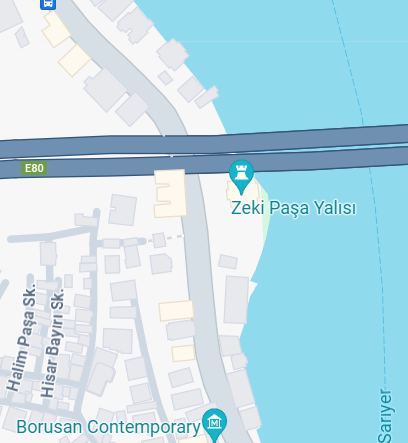


In [5]:
df['Distance'] = ((df['LATITUDE'] - 41.044866)**2 + (df['LONGITUDE'] - 28.943457)**2)**0.5
# 41.044866, 28.943457 Haliç Bridge


In [6]:
# Select the sensor with the smallest distance
closest_sensor = df.loc[df['Distance'].idxmin()]
closest_sensor

DATE_TIME             2024-04-01 00:00:00
LONGITUDE                       28.943481
LATITUDE                        41.042175
GEOHASH                            sxk96x
MINIMUM_SPEED                           2
MAXIMUM_SPEED                         114
AVERAGE_SPEED                          52
NUMBER_OF_VEHICLES                    324
Distance                         0.002691
Name: 1, dtype: object

## Divide the data into train and test set parts. 
I used last 110 samples for test and remaining for train. 

In [7]:
#Reordering columns to have 'NUMBER_OF_VEHICLES' as the last column.
columns = [col for col in df.columns if col != 'NUMBER_OF_VEHICLES'] 
columns.append('NUMBER_OF_VEHICLES')  
df = df[columns]  

# Define the geohash for the closest sensor.
closest_sensor_geohash = 'sxk96x'

# Filtering the dataframe to include only rows with the specified geohash.
filtered_df = df[df['GEOHASH'] == closest_sensor_geohash]

# Dropping unnecessary columns.
filtered_df = filtered_df.drop(columns=['LATITUDE', 'LONGITUDE', 'GEOHASH', 'MAXIMUM_SPEED', 'MINIMUM_SPEED', 'AVERAGE_SPEED'])

# Splitting the data into training and testing sets.
closest_sensor_train_data = filtered_df[:-100]
closest_sensor_test_data = filtered_df[-100:]

# Printing the first few rows of the filtered dataframe and the shapes of the training and testing sets.
print(filtered_df.head())
print(f"Training set shape: {closest_sensor_train_data.shape}")
print(f"Test set shape: {closest_sensor_test_data.shape}")


                 DATE_TIME  Distance  NUMBER_OF_VEHICLES
1      2024-04-01 00:00:00  0.002691                 324
3366   2024-04-01 01:00:00  0.002691                 238
5440   2024-04-01 02:00:00  0.002691                 141
8809   2024-04-01 03:00:00  0.002691                 123
11112  2024-04-01 04:00:00  0.002691                 104
Training set shape: (580, 3)
Test set shape: (100, 3)


In [8]:
#Dropping the 'Distance' column from the filtered dataframe.
filtered_df = filtered_df.drop(columns=['Distance'])

#Printing the first few rows of the filtered dataframe.
print(filtered_df.head())

#Printing the shapes of the training and testing sets.
print(f"Training set shape: {closest_sensor_train_data.shape}")
print(f"Test set shape: {closest_sensor_test_data.shape}")

                 DATE_TIME  NUMBER_OF_VEHICLES
1      2024-04-01 00:00:00                 324
3366   2024-04-01 01:00:00                 238
5440   2024-04-01 02:00:00                 141
8809   2024-04-01 03:00:00                 123
11112  2024-04-01 04:00:00                 104
Training set shape: (580, 3)
Test set shape: (100, 3)


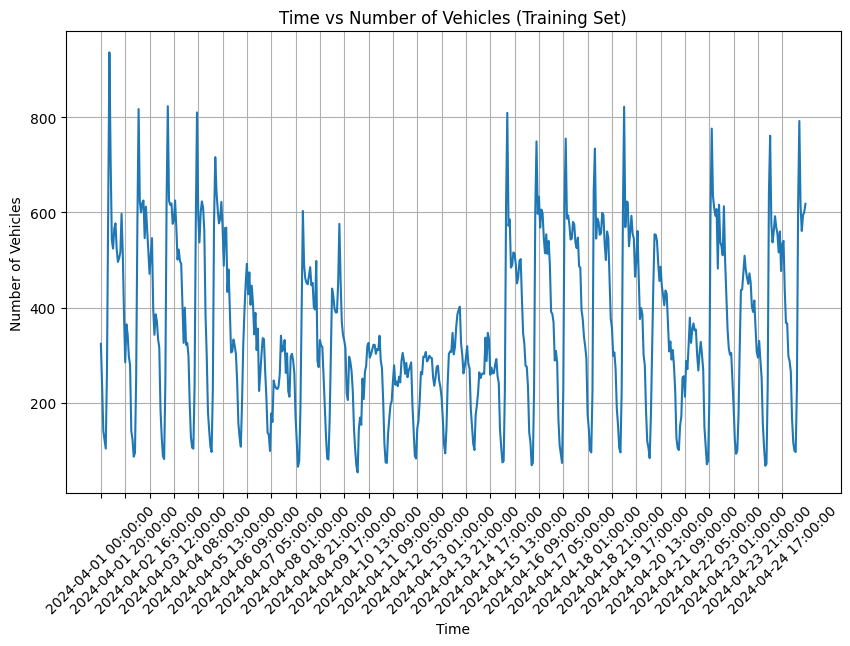

In [9]:
# Select x-ticks to display every 20th label
tick_indices = range(0, len(closest_sensor_train_data['DATE_TIME']), 20)

plt.figure(figsize=(10, 6))
plt.plot(closest_sensor_train_data['DATE_TIME'], closest_sensor_train_data['NUMBER_OF_VEHICLES'])
plt.xlabel('Time')
plt.ylabel('Number of Vehicles')
plt.title('Time vs Number of Vehicles (Training Set)')
plt.xticks(tick_indices, closest_sensor_train_data['DATE_TIME'].iloc[tick_indices], rotation=45)
plt.grid(True)
plt.show()

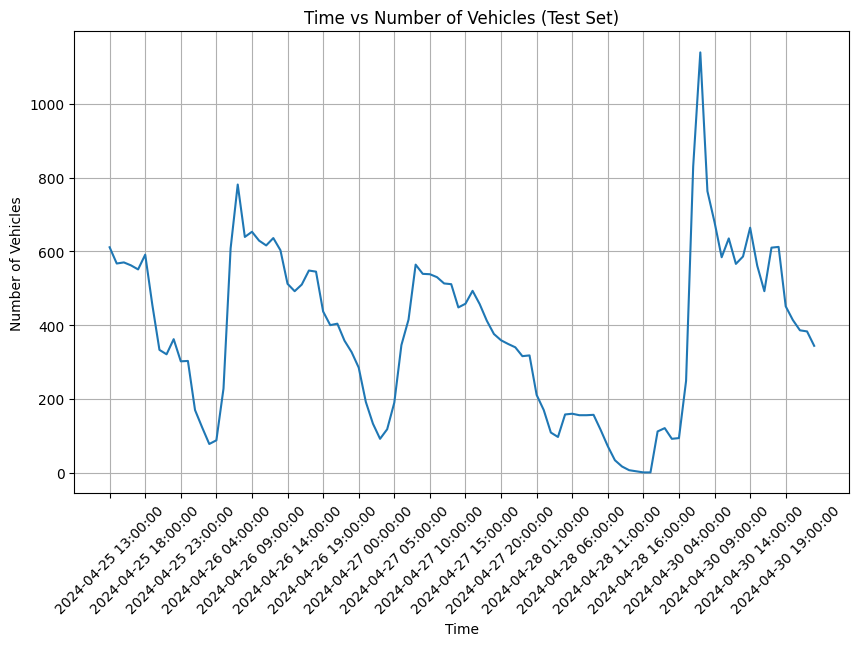

In [10]:
# Select x-ticks to display every 5th label
tick_indices = range(0, len(closest_sensor_test_data['DATE_TIME']), 5)

# Plotting the number of vehicles over time for the test set
plt.figure(figsize=(10, 6))
plt.plot(closest_sensor_test_data['DATE_TIME'], closest_sensor_test_data['NUMBER_OF_VEHICLES'])
plt.xlabel('Time')
plt.ylabel('Number of Vehicles')
plt.title('Time vs Number of Vehicles (Test Set)')  # Updated title for Test Set
plt.xticks(tick_indices, closest_sensor_test_data['DATE_TIME'].iloc[tick_indices], rotation=45)
plt.grid(True)
plt.show()

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

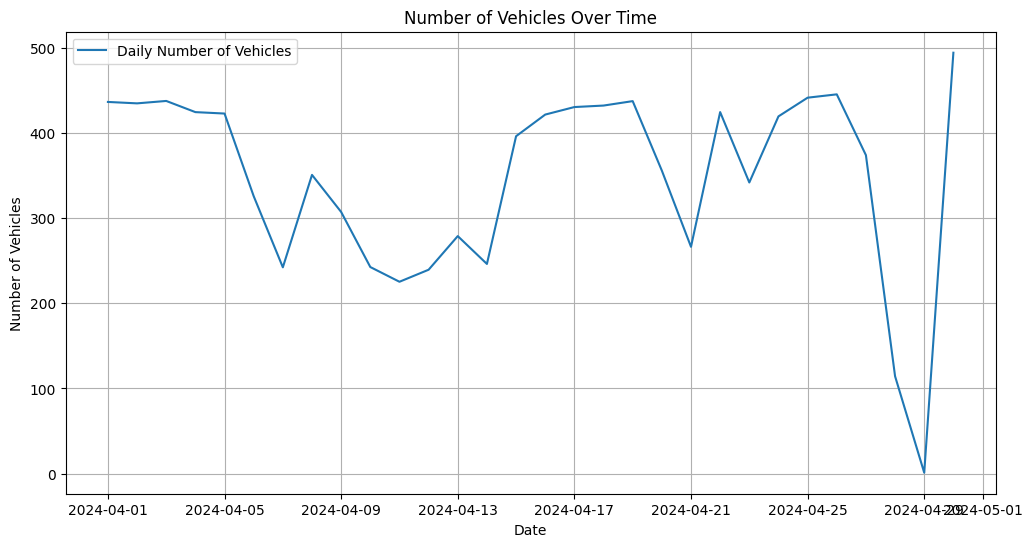

In [12]:
#Converting the 'DATE_TIME' column to datetime.
filtered_df['DATE_TIME'] = pd.to_datetime(filtered_df['DATE_TIME'])

#Setting 'DATE_TIME' as the index.
filtered_df.set_index('DATE_TIME', inplace=True)

#Aggregating data by day.
daily_data = filtered_df['NUMBER_OF_VEHICLES'].resample('D').mean()

#Plotting the raw data to observe general trends.
plt.figure(figsize=(12, 6))
plt.plot(daily_data, label='Daily Number of Vehicles')
plt.title('Number of Vehicles Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.grid(True)
plt.show()

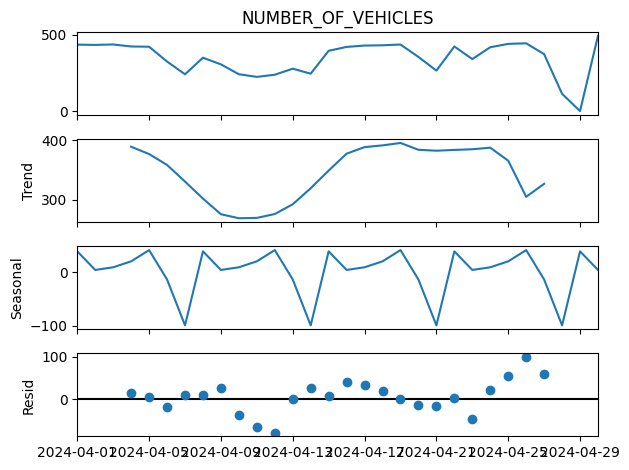

In [13]:
decomposition = seasonal_decompose(daily_data.dropna(), model='additive')  

# Plotting decomposed components.
decomposition.plot()
plt.tight_layout()
plt.show()

## Write a function to prepare the input-target pairs. 
The function basically receives the dataframe and returns X, y numpy arrays with the given prediction window size. 

We can use the actual number of vehicles value, but I scaled it, divided the number of vehicles to 1000 to make the range simple.

In [14]:
closest_sensor_test_data.drop(columns=['Distance'], inplace=True)

closest_sensor_test_data

,DATE_TIME,NUMBER_OF_VEHICLES
1381493,2024-04-25 13:00:00,611
1382049,2024-04-25 14:00:00,567
1385153,2024-04-25 15:00:00,570
1387848,2024-04-25 16:00:00,562
1391166,2024-04-25 17:00:00,551
...,...,...
1603495,2024-04-30 19:00:00,451
1605961,2024-04-30 20:00:00,414
1606269,2024-04-30 21:00:00,386
1609327,2024-04-30 22:00:00,383


In [15]:
import warnings

warnings.filterwarnings('ignore')

In [16]:
def prepare_sequences(df, window_size=24):

    #Scaling vehicle numbers by dividing by 1000.
    scaled_values = df['NUMBER_OF_VEHICLES'].values / 1000
    
    #Creatin sequences.
    X, y = [], []
    
    for i in range(len(scaled_values) - window_size):
        # Input sequence
        sequence = scaled_values[i:(i + window_size)]
        # Target is the next value after the sequence
        target = scaled_values[i + window_size]
        
        X.append(sequence)
        y.append(target)
    
    return np.array(X), np.array(y)

#Preparing sequences for training and testing data.
x_train_tensor, y_train_tensor = prepare_sequences(closest_sensor_train_data, window_size=24)
x_test_tensor, y_test_tensor = prepare_sequences(closest_sensor_test_data, window_size=24)

#Printing the shapes of the prepared tensors.
print("x_train_tensor shape:", x_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)
print("x_test_tensor shape:", x_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

x_train_tensor shape: (556, 24)
y_train_tensor shape: (556,)
x_test_tensor shape: (76, 24)
y_test_tensor shape: (76,)


## a) Calculate a baseline Prediction score by repeating the previous value

For example:

y_test
array([0.537, 0.592, 0.538, 0.61 ])

prediction is 

array([0.144, 0.537, 0.592, 0.538])



In [17]:
def calculate_baseline_score(df):
    # Datetime conversion.
    df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])
    
    #Sorting by datetime to ensure order.
    df = df.sort_values(by='DATE_TIME')
    
    #Baseline prediction: repeatting the previous value.
    df['baseline_prediction'] = df['NUMBER_OF_VEHICLES'].shift(1)
    
    #Calculating Mean Absolute Error (MAE) as a baseline score.
    mae = abs(df['NUMBER_OF_VEHICLES'] - df['baseline_prediction']).mean()
    return mae

baseline_score_train = calculate_baseline_score(closest_sensor_train_data),
baseline_score_test = calculate_baseline_score(closest_sensor_test_data)

print("Baseline MAE (Training Set):", baseline_score_train)
print("Baseline MAE (Test Set):", baseline_score_test)

Baseline MAE (Training Set): (58.30742659758204,)
Baseline MAE (Test Set): 61.303030303030305


## Plot the baseline prediction vs y_test on the same plot

Yes, it looks very similar acceptible but that is a bit illusion. See the error plot. Which shows errors in each time-step

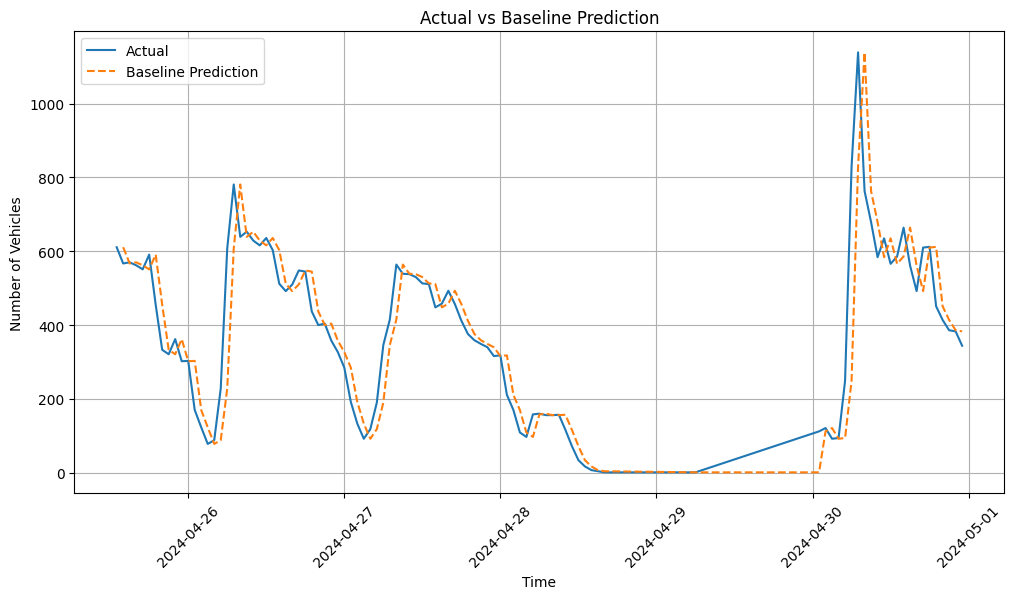

In [18]:
closest_sensor_test_data['baseline_prediction'] = closest_sensor_test_data['NUMBER_OF_VEHICLES'].shift(1)

# Plot the actual vs baseline prediction
plt.figure(figsize=(12, 6))
plt.plot(closest_sensor_test_data['DATE_TIME'], closest_sensor_test_data['NUMBER_OF_VEHICLES'], label='Actual')
plt.plot(closest_sensor_test_data['DATE_TIME'], closest_sensor_test_data['baseline_prediction'], label='Baseline Prediction', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Number of Vehicles')
plt.title('Actual vs Baseline Prediction')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Implement a model trainer, given a model, x and y , criterion, optimizer, batch_size and epochs it trains a a model

* I recommend starting with batch_size=1, because data is so small. Also you may need a grad_clip in some cases to control the exploding gradient.


### Implement a linear model.  LinearPredictor 


You can try with different predictor window_sizes my result is just using previous 6 value to predict the next value. Linear(1,1)

In [19]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


class LinearPredictor(nn.Module):
    def __init__(self, window_size=6):
        super(LinearPredictor, self).__init__()
        self.linear = nn.Linear(window_size, 1)
    
    def forward(self, x):
        return self.linear(x).squeeze()

def train_and_visualize(model, train_df, test_df, window_size=6, criterion=nn.MSELoss(), 
                       optimizer=None, batch_size=1, epochs=100, grad_clip=1.0):
    # Prepare sequences.
    X_train, y_train = prepare_sequences(train_df, window_size)
    X_test, y_test = prepare_sequences(test_df, window_size)
    
    # Convertting to PyTorch tensors.
    X_train = torch.FloatTensor(X_train)
    y_train = torch.FloatTensor(y_train)
    X_test = torch.FloatTensor(X_test)
    y_test = torch.FloatTensor(y_test)
    
    # Creating datasetsi and dataloaders.
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initializing optimizer if not provided
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    train_losses = []
    test_losses = []
    
    # Train loop.
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Evaluation phase.
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_losses.append(test_loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}]')
            print(f'Training Loss: {avg_train_loss:.4f}')
            print(f'Test Loss: {test_loss.item():.4f}\n')
    
    #Generating predictions for visualization.
    model.eval()
    with torch.no_grad():
        predictions = model(X_test).numpy()
        
    #Creating visualization.
    plt.figure(figsize=(15, 8))
    
    #Plotting Training and Test Losses.
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss Over Time')
    plt.legend()
    
    #Plot Predicted vs Actual Values.
    plt.subplot(2, 1, 2)
    
    # Multiply by 1000 to show actual vehicle numbers
    plt.plot(y_test.numpy() * 1000, label='Actual', marker='o')
    plt.plot(predictions * 1000, label='Predicted', marker='x')
    plt.xlabel('Time Step')
    plt.ylabel('Number of Vehicles')
    plt.title('Predicted vs Actual Vehicle Numbers (Test Set)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model, train_losses, test_losses, predictions

Epoch [10/100]
Training Loss: 0.0074
Test Loss: 0.0091

Epoch [20/100]
Training Loss: 0.0071
Test Loss: 0.0093

Epoch [30/100]
Training Loss: 0.0075
Test Loss: 0.0090

Epoch [40/100]
Training Loss: 0.0075
Test Loss: 0.0113

Epoch [50/100]
Training Loss: 0.0073
Test Loss: 0.0092

Epoch [60/100]
Training Loss: 0.0073
Test Loss: 0.0095

Epoch [70/100]
Training Loss: 0.0073
Test Loss: 0.0090

Epoch [80/100]
Training Loss: 0.0071
Test Loss: 0.0092

Epoch [90/100]
Training Loss: 0.0076
Test Loss: 0.0093

Epoch [100/100]
Training Loss: 0.0073
Test Loss: 0.0091



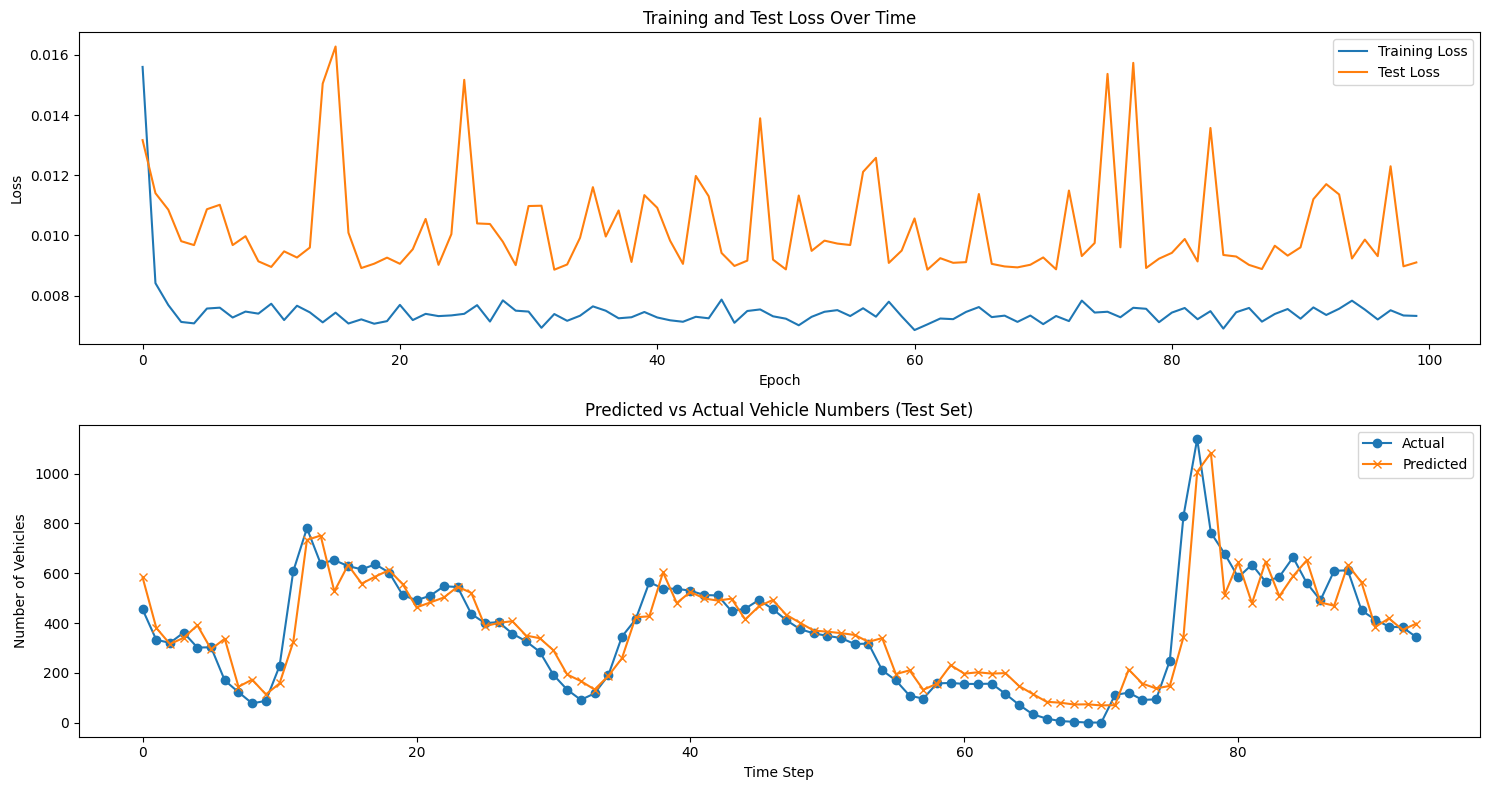

In [20]:
window_size = 6
model = LinearPredictor(window_size=window_size)

# Train and visualize
model, train_losses, test_losses, predictions = train_and_visualize(
    model=model,
    train_df=closest_sensor_train_data,  # Your training DataFrame
    test_df=closest_sensor_test_data,    # Your testing DataFrame
    window_size=window_size,
    epochs=100
)

### Implement a RNN model.  RNNPredictor 


You can try with different predictor window_sizes my result is just using previous 1 value to predict the next value. My model was as follows:

rnn_model = RNNPredictor(1, 64, 1)

I did not clean the errors in first or last time-steps. I am sure you can do better.

In [21]:
import torch
import torch.nn as nn

class RNNPredictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1, num_layers=1):
        super(RNNPredictor, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # RNN layer
        self.rnn = nn.RNN(
            input_size=input_size,              # The number of expected features in the input
            hidden_size=hidden_size,            # The number of features in the hidden state
            num_layers=num_layers,              # Number of recurrent layers
            batch_first=True                    # Input and output tensors are provided as (batch, seq, feature)
        )
        
        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)       # A fully connected layer to map the hidden state to the output
    
    def forward(self, x):
        # Reshape input for RNN if necessary: (batch_size, seq_len, input_size)
        if len(x.shape) == 2:
            x = x.unsqueeze(-1)
            
        #Initializing hidden state with zeros.
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        #Forward propagate RNN.
        out, _ = self.rnn(x, h0)
        
        #Decoding the hidden state of the last time step.
        out = self.fc(out[:, -1, :])
        
        return out.squeeze()  

# Modified training function to handle the RNN model.
def train_and_visualize_rnn(model, train_df, test_df, window_size=1, 
                           criterion=nn.MSELoss(), learning_rate=0.01,
                           batch_size=1, epochs=100, grad_clip=1.0):
    # Prepare sequences
    X_train, y_train = prepare_sequences(train_df, window_size)
    X_test, y_test = prepare_sequences(test_df, window_size)
    
    #Converting to PyTorch tensors.
    X_train = torch.FloatTensor(X_train)
    y_train = torch.FloatTensor(y_train)
    X_test = torch.FloatTensor(X_test)
    y_test = torch.FloatTensor(y_test)
    
    # Create datasets and dataloaders.
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize optimizer.
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []
    
    # Train loop.
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            
            optimizer.step()
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        #Evaluation phase.
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_losses.append(test_loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}]')
            print(f'Training Loss: {avg_train_loss:.4f}')
            print(f'Test Loss: {test_loss.item():.4f}\n')
    
    #Generating predictions for visualization.
    model.eval()
    with torch.no_grad():
        predictions = model(X_test).numpy()
    
    #Visualizing results.
    plt.figure(figsize=(15, 8))
    
    #Plot Training and Test Losses.
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss Over Time')
    plt.legend()
    
    #Plot  Predicted vs Actual Values.
    plt.subplot(2, 1, 2)
    plt.plot(y_test.numpy() * 1000, label='Actual', marker='o')
    plt.plot(predictions * 1000, label='Predicted', marker='x')
    plt.xlabel('Time Step')
    plt.ylabel('Number of Vehicles')
    plt.title('Predicted vs Actual Vehicle Numbers (Test Set)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model, train_losses, test_losses, predictions

Epoch [10/50]
Training Loss: 0.0107
Test Loss: 0.0121

Epoch [20/50]
Training Loss: 0.0094
Test Loss: 0.0102

Epoch [30/50]
Training Loss: 0.0089
Test Loss: 0.0104

Epoch [40/50]
Training Loss: 0.0088
Test Loss: 0.0107

Epoch [50/50]
Training Loss: 0.0092
Test Loss: 0.0112



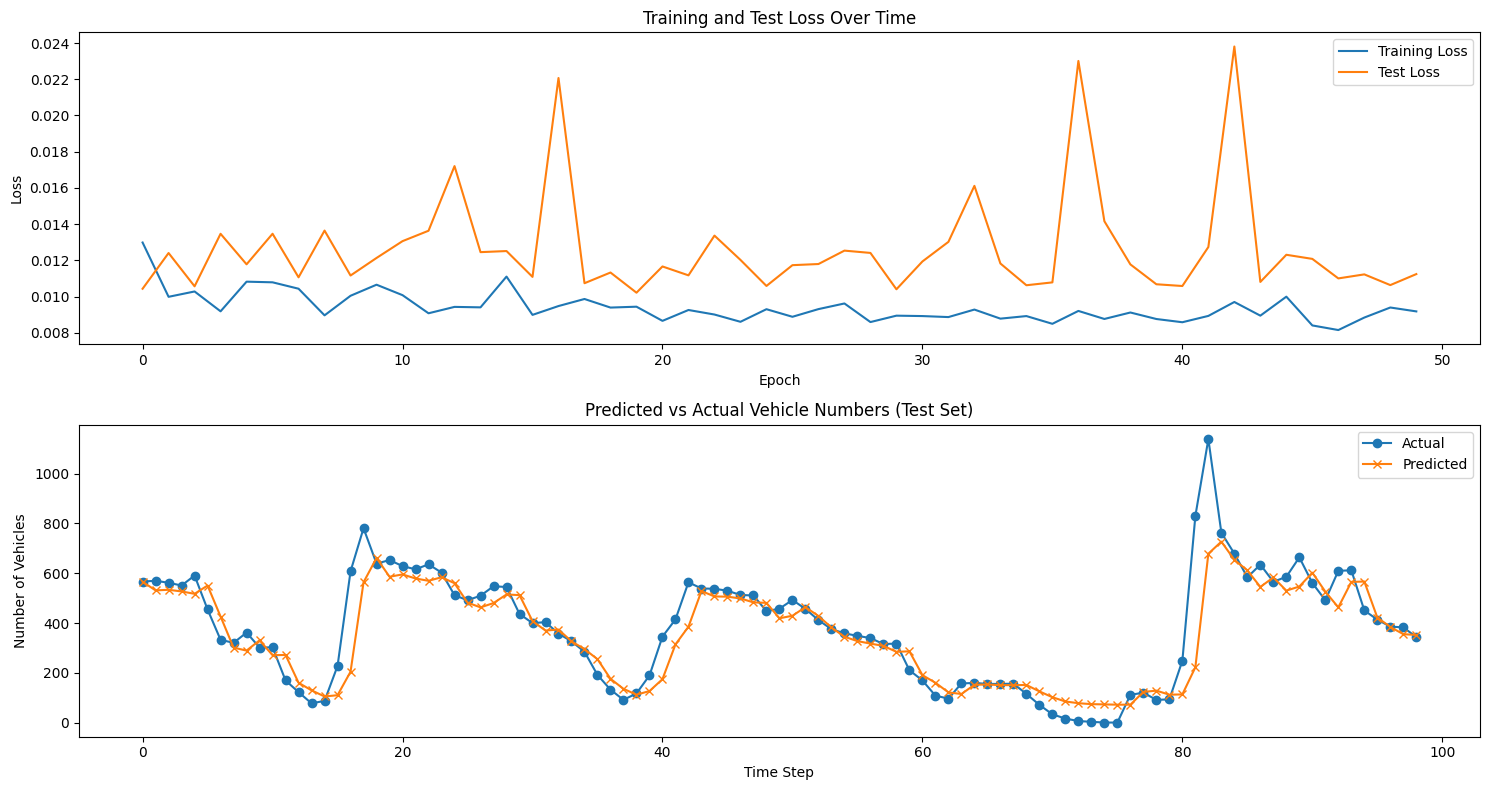

In [22]:
#Initialize model.
rnn_model = RNNPredictor(input_size=1, hidden_size=64, output_size=1)

#Train and visualize.
model, train_losses, test_losses, predictions = train_and_visualize_rnn(
    model=rnn_model,
    train_df=closest_sensor_train_data,
    test_df=closest_sensor_test_data,
    window_size=1,
    epochs=50
)

## Implement a CNN model. CNNPredictor
You can try with different predictor window_sizes my result is just using previous 1 value to predict the next value. My model was as follows:

cnn_model = ConvPredictor(1, num_filters=4, 1

I did not clean the errors in first or last time-steps. I am sure you can do better.

However, applying convolution, make sure you do not break the causality. Using the future values (to be predicted values) as input in the model. 

In [23]:
import torch
import torch.nn as nn

class CNNPredictor(nn.Module):
    def __init__(self, window_size=1, num_filters=4, output_size=1):
        super(CNNPredictor, self).__init__()
        
        # Define the first convolutional layer
        # For window_size=1, we need to adjust kernel_size to 1
        self.conv1 = nn.Conv1d(
            in_channels=1,
            out_channels=num_filters,
            kernel_size=1,  # Changed to 1 to handle single input
            padding=0
        )
        
        # Calculate the output size after convolution
        self.conv_output_size = window_size
        
        # Define the flatten and dense layers
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(num_filters * self.conv_output_size, output_size)
        
        # Define the activation function
        self.activation = nn.ReLU()
    
    def forward(self, x):
        # Reshape input: (batch_size, channels, sequence_length)
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        
        # Apply convolution and activation function
        x = self.activation(self.conv1(x))
        
        # Flatten the output and pass through the dense layer
        x = self.flatten(x)
        x = self.fc(x)
        
        # Return the final output
        return x.squeeze()

def train_and_visualize_cnn(model, train_df, test_df, window_size=1, 
                           criterion=nn.MSELoss(), learning_rate=0.01,
                           batch_size=1, epochs=100, grad_clip=1.0):
    # Preparing sequences
    X_train, y_train = prepare_sequences(train_df, window_size)
    X_test, y_test = prepare_sequences(test_df, window_size)
    
    # Converting to PyTorch tensors
    X_train = torch.FloatTensor(X_train)
    y_train = torch.FloatTensor(y_train)
    X_test = torch.FloatTensor(X_test)
    y_test = torch.FloatTensor(y_test)
    
    # Creating datasets and dataloaders
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initializing optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []
    
    # Train loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            
            optimizer.step()
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Evaluation phase
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_losses.append(test_loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}]')
            print(f'Training Loss: {avg_train_loss:.4f}')
            print(f'Test Loss: {test_loss.item():.4f}\n')
    
    # Generatşng predictions for visualization.
    model.eval()
    with torch.no_grad():
        predictions = model(X_test).numpy()
    
    # Visualizing results.
    plt.figure(figsize=(15, 8))
    
    # Plot Training and Test Losses.
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss Over Time')
    plt.legend()
    
    # Plot Predicted vs Actual Values.
    plt.subplot(2, 1, 2)
    plt.plot(y_test.numpy() * 1000, label='Actual', marker='o')
    plt.plot(predictions * 1000, label='Predicted', marker='x')
    plt.xlabel('Time Step')
    plt.ylabel('Number of Vehicles')
    plt.title('Predicted vs Actual Vehicle Numbers (Test Set)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model, train_losses, test_losses, predictions



Epoch [10/50]
Training Loss: 0.0060
Test Loss: 0.0122

Epoch [20/50]
Training Loss: 0.0057
Test Loss: 0.0155

Epoch [30/50]
Training Loss: 0.0058
Test Loss: 0.0095

Epoch [40/50]
Training Loss: 0.0056
Test Loss: 0.0106

Epoch [50/50]
Training Loss: 0.0057
Test Loss: 0.0087



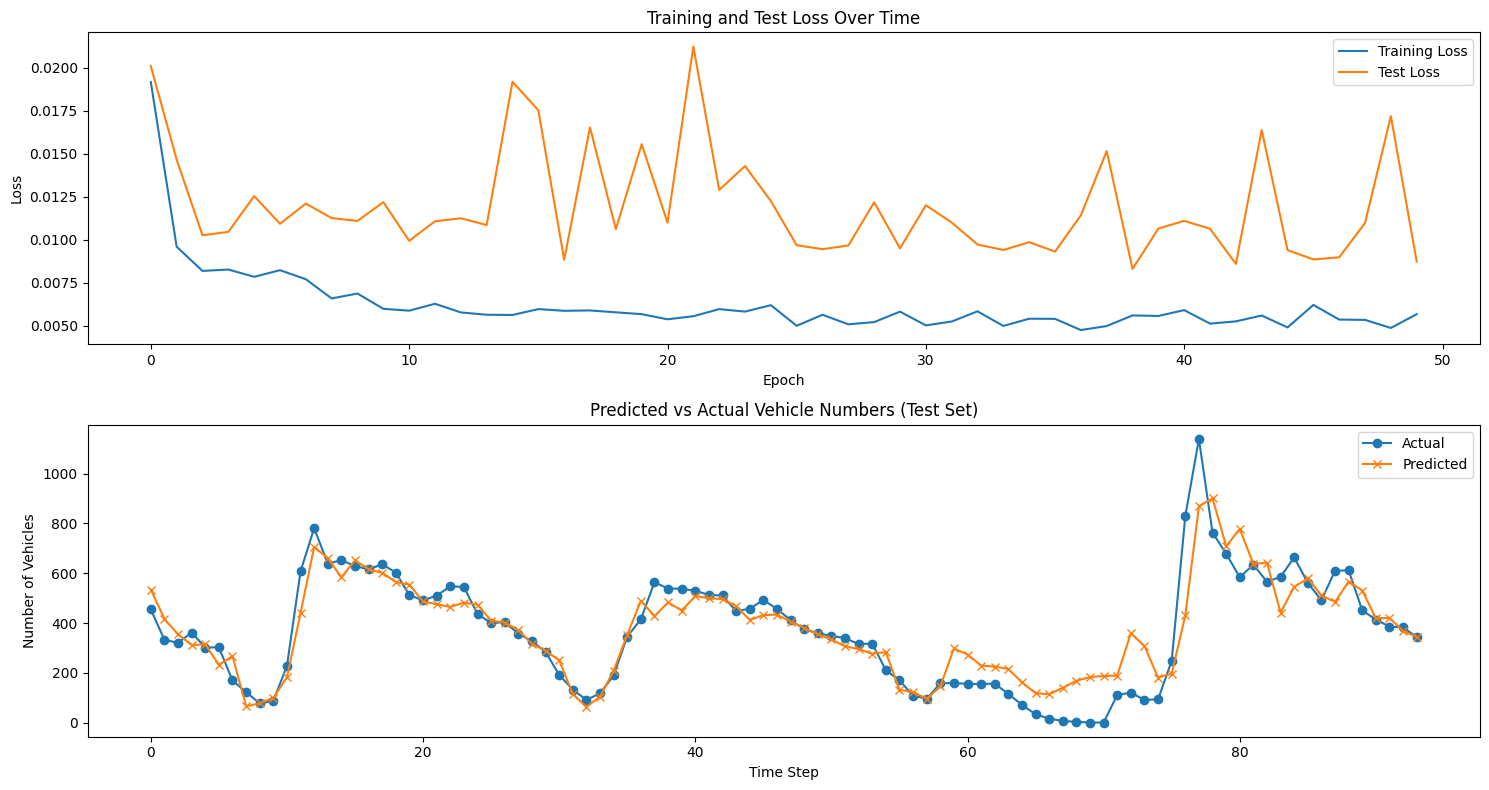

In [24]:
# Initializing model.
window_size = 6
cnn_model = CNNPredictor(window_size=window_size, num_filters=4, output_size=1)

# Train and visualize.
model, train_losses, test_losses, predictions = train_and_visualize_cnn(
    model=cnn_model,
    train_df=closest_sensor_train_data,
    test_df=closest_sensor_test_data,
    window_size=window_size,
    epochs=50
)

## Train an Temporal Convolution Network or Transformer model. What factors influenced your decision?
a) Explain the important features of the dataset (e.g., size, patterns, noise, or missing values) that affected your choice of model. Compare these features with the strengths and weaknesses of TCNs and Transformers.

b) Which pre-trained transformer model (if any) did you use, and why? Explain why you chose your model design (e.g., number of layers, kernel sizes for TCN, or initialization, fine-tuning, attention heads for Transformers). How do these choices match the dataset and the prediction task?

In [25]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm

class Chomp1d(nn.Module):

    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size]

class TemporalBlock(nn.Module):

    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        # First convolutional layer
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                         stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        # Second convolutional layer
        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                         stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        # Sequentially applying the layers
        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                               self.conv2, self.chomp2, self.relu2, self.dropout2)
        # Downsample layer to match the input and output dimensions if necessary
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        # Initialize weights of the convolutional layers
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        # Forward pass through the network
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

    def init_weights(self):
        # Initialize weights of the convolutional layers
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        # Forward pass through the network
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TemporalConvNet(nn.Module):
    # A Temporal Convolutional Network (TCN) with a series of Temporal Blocks.
    def __init__(self, num_inputs=1, num_channels=[32, 32, 16], kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size,
                                   stride=1, dilation=dilation_size,
                                   padding=(kernel_size-1) * dilation_size,
                                   dropout=dropout)]

        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], 1)

    def forward(self, x):
        # Forward pass through the network
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        x = self.network(x)
        x = x[:, :, -1]  # Take the last time step
        return self.linear(x).squeeze()

Epoch [10/100]
Training Loss: 0.0041
Test Loss: 0.0059

Epoch [20/100]
Training Loss: 0.0033
Test Loss: 0.0080

Epoch [30/100]
Training Loss: 0.0031
Test Loss: 0.0066

Epoch [40/100]
Training Loss: 0.0029
Test Loss: 0.0058

Epoch [50/100]
Training Loss: 0.0025
Test Loss: 0.0053

Epoch [60/100]
Training Loss: 0.0030
Test Loss: 0.0045

Epoch [70/100]
Training Loss: 0.0030
Test Loss: 0.0051

Epoch [80/100]
Training Loss: 0.0026
Test Loss: 0.0057

Epoch [90/100]
Training Loss: 0.0026
Test Loss: 0.0061

Epoch [100/100]
Training Loss: 0.0025
Test Loss: 0.0045



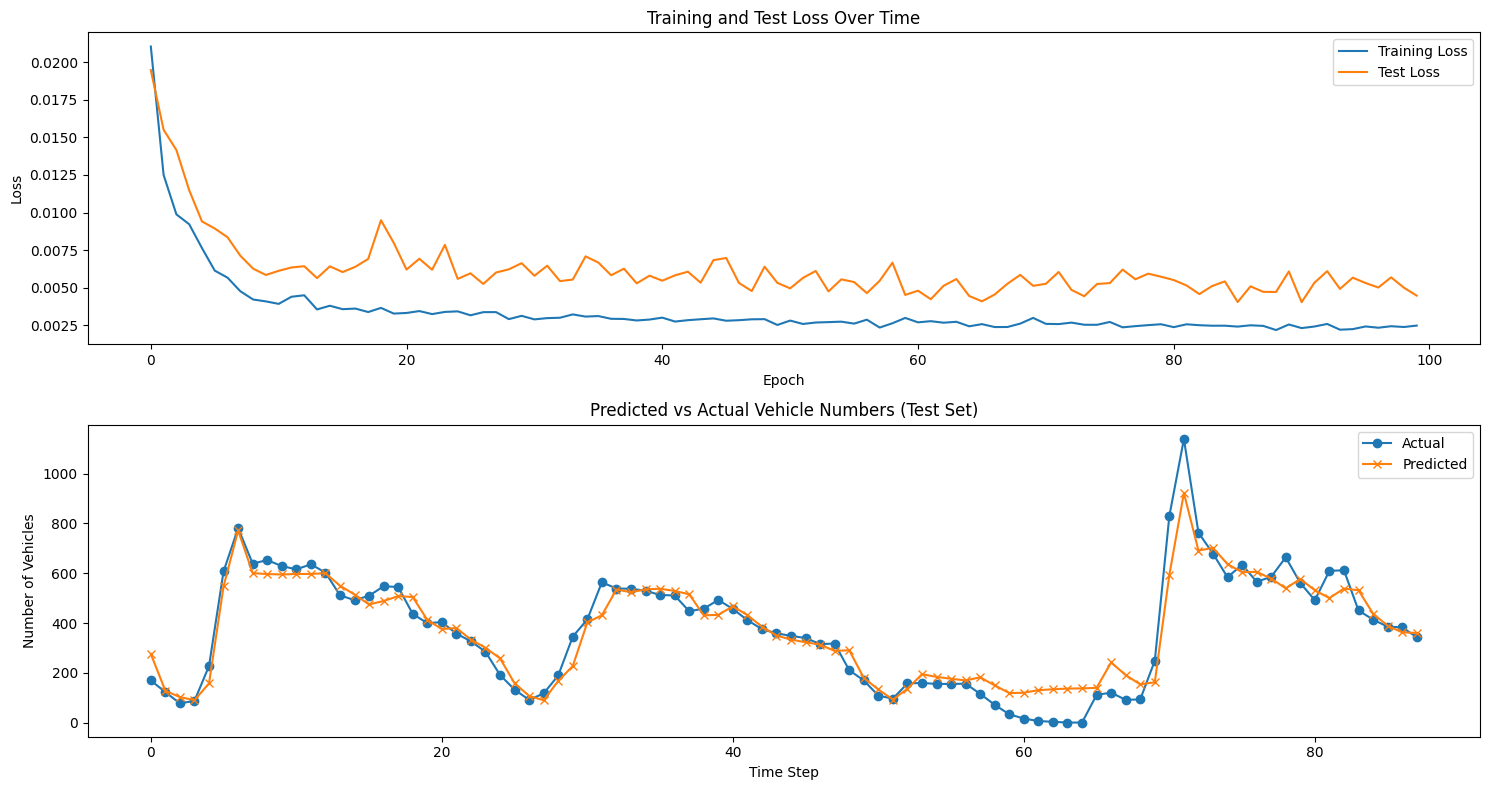

In [26]:
# Initialize model
tcn_model = TemporalConvNet(num_inputs=1, num_channels=[32, 32, 16], kernel_size=2)

# Train model using the same training function as before
model, train_losses, test_losses, predictions = train_and_visualize_cnn(
    model=tcn_model,
    train_df=closest_sensor_train_data,
    test_df=closest_sensor_test_data,
    window_size=12,  
    epochs=100,
    learning_rate=0.001,
    batch_size=1
)

## Compare all the obtained results. 

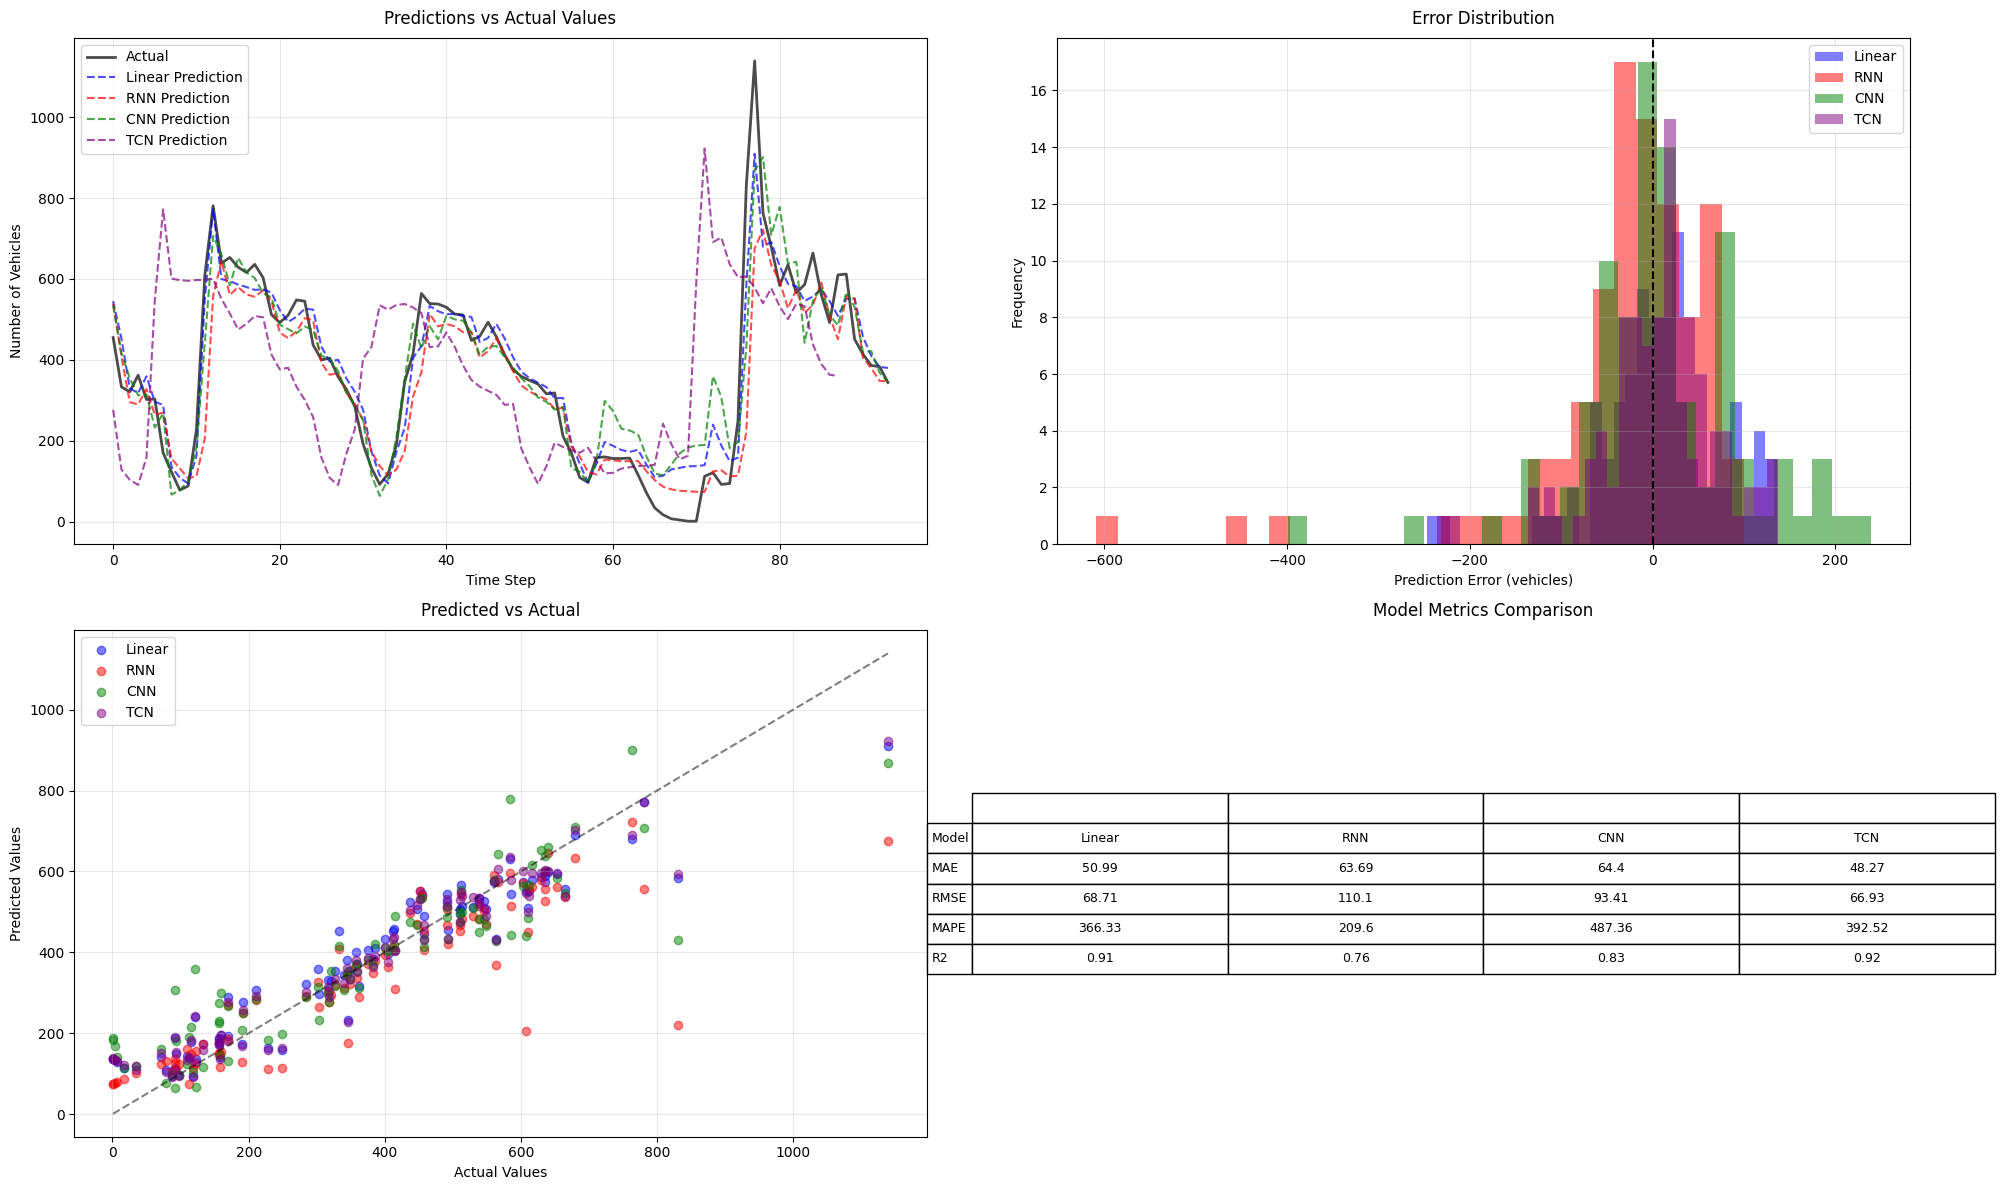


Detailed Metrics:

Linear Model:
MAE: 50.99 vehicles
RMSE: 68.71 vehicles
MAPE: 366.33%
R2 Score: 0.9059

RNN Model:
MAE: 63.69 vehicles
RMSE: 110.10 vehicles
MAPE: 209.60%
R2 Score: 0.7584

CNN Model:
MAE: 64.40 vehicles
RMSE: 93.41 vehicles
MAPE: 487.36%
R2 Score: 0.8261

TCN Model:
MAE: 48.27 vehicles
RMSE: 66.93 vehicles
MAPE: 392.52%
R2 Score: 0.9161


In [27]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

def compare_models(models_config, test_df):

    predictions = {}
    metrics = {}
    
    # Get predictions from all models.
    for name, config in models_config.items():
        model = config['model']
        window_size = config['window_size']
        
        # Prepare test data for this specific model.
        X_test, y_test = prepare_sequences(test_df, window_size)
        X_test_tensor = torch.FloatTensor(X_test)
        
        model.eval()
        with torch.no_grad():
            pred = model(X_test_tensor).numpy()
            predictions[name] = {
                'pred': pred * 1000,
                'actual': y_test * 1000
            }
    
    # Calculate metrics for each model.
    for name, pred_dict in predictions.items():
        pred = pred_dict['pred']
        actual = pred_dict['actual']
        
        mae = mean_absolute_error(actual, pred)
        rmse = np.sqrt(mean_squared_error(actual, pred))
        mape = np.mean(np.abs((actual - pred) / actual)) * 100
        r2 = r2_score(actual, pred)
        
        metrics[name] = {
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape,
            'R2': r2
        }
    
    # Plotting.
    plt.rcParams['figure.figsize'] = [20, 12]
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.3
    
    fig = plt.figure()
    
    # 1. Time Series Plot
    plt.subplot(2, 2, 1)
    # Plot first actual values only once
    first_model = list(predictions.keys())[0]
    plt.plot(predictions[first_model]['actual'], 'k-', label='Actual', linewidth=2, alpha=0.7)
    colors = ['blue', 'red', 'green', 'purple']
    for (name, pred_dict), color in zip(predictions.items(), colors):
        plt.plot(pred_dict['pred'], '--', label=f'{name} Prediction', alpha=0.7, color=color)
    plt.title('Predictions vs Actual Values', fontsize=12, pad=10)
    plt.xlabel('Time Step')
    plt.ylabel('Number of Vehicles')
    plt.legend()
    
    # 2. Error Distribution
    plt.subplot(2, 2, 2)
    for (name, pred_dict), color in zip(predictions.items(), colors):
        errors = pred_dict['pred'] - pred_dict['actual']
        plt.hist(errors, bins=30, alpha=0.5, label=name, color=color)
    plt.axvline(x=0, color='k', linestyle='--')
    plt.title('Error Distribution', fontsize=12, pad=10)
    plt.xlabel('Prediction Error (vehicles)')
    plt.ylabel('Frequency')
    plt.legend()
    
    # 3. Scatter Plot
    plt.subplot(2, 2, 3)
    for (name, pred_dict), color in zip(predictions.items(), colors):
        actual = pred_dict['actual']
        pred = pred_dict['pred']
        plt.scatter(actual, pred, alpha=0.5, label=name, color=color)
    
    # Get overall min and max for diagonal line
    all_vals = np.concatenate([pred_dict['actual'] for pred_dict in predictions.values()])
    min_val = np.min(all_vals)
    max_val = np.max(all_vals)
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
    
    plt.title('Predicted vs Actual', fontsize=12, pad=10)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    
    # 4. Metrics Comparison
    plt.subplot(2, 2, 4)
    metrics_df = pd.DataFrame(metrics).round(2)
    plt.axis('off')
    table = plt.table(cellText=np.vstack((metrics_df.columns, metrics_df.values)),
                     colLabels=[''] * len(metrics_df.columns),
                     rowLabels=['Model'] + list(metrics_df.index),
                     loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    plt.title('Model Metrics Comparison', fontsize=12, pad=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed metrics
    print("\nDetailed Metrics:")
    print("=" * 50)
    for name, metric in metrics.items():
        print(f"\n{name} Model:")
        print(f"MAE: {metric['MAE']:.2f} vehicles")
        print(f"RMSE: {metric['RMSE']:.2f} vehicles")
        print(f"MAPE: {metric['MAPE']:.2f}%")
        print(f"R2 Score: {metric['R2']:.4f}")
    
    return metrics

# Example usage:
models_config = {
    'Linear': {
        'model': model,
        'window_size': 6  # or whatever window size you used for linear model
    },
    'RNN': {
        'model': rnn_model,
        'window_size': 6  # or whatever window size you used for RNN
    },
    'CNN': {
        'model': cnn_model,
        'window_size': 6  # or whatever window size you used for CNN
    },
    'TCN': {
        'model': tcn_model,
        'window_size': 12  # or whatever window size you used for TCN
    }
}

metrics = compare_models(
    models_config=models_config,
    test_df=closest_sensor_test_data
)

# I chose to use a TCN not a transformer because, Time series data requires models that respect the chronological order, meaning predictions at time 𝑡 should not use information from future time steps. TCNs employ causal convolutions, ensuring that the model only considers past and current inputs for any given prediction. That is why it is more appropriate to use in time series data. Transformer uses positional encodings to capture sense of order and it may may not inherently capture the sequential nature of time series as well as TCNs.

# All columns are dropped beside of datetime, because I are trying to predict onyl one sensor. Therefore, I dropped other columns only feature that matters is time.